## Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
seed = 34

np.random.seed(seed)

## Carga de datos 

#### Exploración información base

De la definición del reto extraemos el significado de cada columna y también apuntamos **pistas**/**indicaciones** necesarias para la correcta realización del reto que se nos ha propuesto

> "las OF (Orden de Fabiración) o lotes que no estén en esta tabla no se deben tener en cuenta"


In [3]:
df_info_general = pd.read_excel('raw_data/OF 123456 v02.xlsx', engine='openpyxl')
df_info_general.head(5)

,Orden,Número material,Texto breve material,Lote,Cantidad entregada,Unidad de medida
0,200178572,123456,MATERIAL DESCRITION,23/019,13.8,L
1,200179217,123456,MATERIAL DESCRITION,23/020,13.6,L
2,200181620,123456,MATERIAL DESCRITION,23/021,13.5,L
3,200182428,123456,MATERIAL DESCRITION,23/022,13.8,L
4,200182429,123456,MATERIAL DESCRITION,23/023,13.7,L


Comprobamos que el tipo de datos se han inferido correctamente y no hay valores nulos

In [4]:
df_info_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Orden                 207 non-null    int64  
 1   Número material       207 non-null    int64  
 2   Texto breve material  207 non-null    object 
 3   Lote                  207 non-null    object 
 4   Cantidad entregada    207 non-null    float64
 5   Unidad de medida      207 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.8+ KB


In [5]:
df_info_general[['Número material', 'Texto breve material', 'Unidad de medida']].nunique()

Número material         1
Texto breve material    1
Unidad de medida        1
dtype: int64

Efectivamente esta tabla solamente pertenece a un mismo material `123456`, misma descripción y la misma unidad de medida para la cantidad de material

In [6]:
# Guardamos las ordenes y lotes para poder 'cruzar' con otras tablas
ordenes = df_info_general['Orden'].unique()
lotes = df_info_general['Lote'].unique()

print(f"Total ordenes únicas {len(ordenes)}")
print(f"Total lotes únicos {len(lotes)}")

Total ordenes únicas 207
Total lotes únicos 207


Parece ser que hay una relación 1-1 entre las ordenes y lotes

La única columna que interesaría saber algun dato estadístico es el de la cantidad entregada de material, dado que el resto son valores categóricos o de por si no tienen gran significado y se podría prescindir de ellas

In [7]:
df_info_general['Cantidad entregada'].describe()

count    207.000000
mean      13.540580
std        1.358163
min        0.000000
25%       13.600000
50%       13.700000
75%       13.780000
max       14.000000
Name: Cantidad entregada, dtype: float64

La cantidad entregada parece ser muy estable, con ello queremos decir que suele rondar los mismos valores por cada orden/lote. La variación entre lotes es mínima, lo cual ya nos da indicios de que habrá que fijarse con lupa en décimas/centésimas para saber si la producción es óptima

#### Exploración diferentes fases producción

Todos los datos se encuentran en el mismo archivo, pero en hojas de Excel diferentes por lo que las cachearemos en *dataframes* diferentes para más comodidad

#####  Preinóculo

Esta hoja tiene como algo "especial" la cabecera, ya que se conforma por dos líneas. La cargaremos y renombraremos para que sea más legible

In [30]:
df_preinoculo = pd.read_excel('raw_data/Fases producción v02.xlsx', sheet_name='Preinóculo', header=[0, 1], na_values=['NA', 'N.A'], engine='openpyxl')
df_preinoculo.head(5)

Unnamed: 0_level_0  Unnamed: 1_level_0  Unnamed: 2_level_0      pH          \
                LOTE   Fecha/hora inicio      Fecha/hora fin línea 1 línea 2   
0              23023 2023-03-26 05:00:00 2023-03-27 07:21:00   5.496   5.504   
1              23024 2023-03-26 05:00:00 2023-03-27 07:21:00   5.496   5.504   
2              23025 2023-03-17 06:00:00 2023-03-28 07:42:00   5.480   5.520   
3              23026 2023-03-17 06:00:00 2023-03-28 07:42:00   5.480   5.520   
4              23027 2023-04-02 05:00:00 2023-04-03 13:30:00   5.384   5.440   

          Turbidez                 Línea utilizada                  
  línea 3  línea 1 línea 2 línea 3         línea 1 línea 2 línea 3  
0    5.52    28.32   27.92   32.00               1       1       0  
1    5.52    28.32   27.92   32.00               1       1       0  
2    5.52    26.56   27.52   26.40               1       1       0  
3    5.52    26.56   27.52   26.40               1       1       0  
4    5.40    33.84   30.56   32.48               1       0       1

In [31]:
df_preinoculo.shape

(165, 12)

Reducimos/simplificamos las columnas para que sea más fácil leer y acceder a ellas

In [32]:
new_cols = [l2 if 'Unnamed' in l1 else f"{l1} {l2}" for l1, l2 in df_preinoculo.columns.to_list()]
df_preinoculo.columns = new_cols
df_preinoculo['LOTE'] = df_preinoculo['LOTE'].apply(lambda l: int(l.replace('P','')) if type(l) != int else l)
df_preinoculo.head(5)

,LOTE,Fecha/hora inicio,Fecha/hora fin,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3,Línea utilizada línea 1,Línea utilizada línea 2,Línea utilizada línea 3
0,23023,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.52,28.32,27.92,32.00,1,1,0
1,23024,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.52,28.32,27.92,32.00,1,1,0
2,23025,2023-03-17 06:00:00,2023-03-28 07:42:00,5.480,5.520,5.52,26.56,27.52,26.40,1,1,0
3,23026,2023-03-17 06:00:00,2023-03-28 07:42:00,5.480,5.520,5.52,26.56,27.52,26.40,1,1,0
4,23027,2023-04-02 05:00:00,2023-04-03 13:30:00,5.384,5.440,5.40,33.84,30.56,32.48,1,0,1


Si echamos la vista atras, la columna de `LOTE` no tiene los mismos valores con barras como en la tabla anterior, sino mas bien es un número entero. 
Para poder fijarnos exclusivamente en los lotes que nos interesa tenemos que transformar su formato. 
**NOTA** Esto es importante para la limpieza y mezcla de tablas posterior, ahora tan solo nos ayudara a ser mas concisos con la exploración

In [33]:
LOTES = [int(l.replace('/', '').replace('P', '')) for l in lotes]
len(LOTES)

207

Se reduce ligeramente el conjunto de datos con este "cruce" sencillo con la tabla base de ordenes/lotes

In [34]:
df_preinoculo = df_preinoculo[df_preinoculo['LOTE'].isin(LOTES)]
df_preinoculo.shape

(154, 12)

Viendo la información resumida de los datos cargados, vemos que en algunas columnas hay valores perdidos

In [35]:
df_preinoculo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 0 to 163
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   LOTE                     154 non-null    int64         
 1   Fecha/hora inicio        154 non-null    datetime64[ns]
 2   Fecha/hora fin           154 non-null    datetime64[ns]
 3   pH línea 1               152 non-null    float64       
 4   pH línea 2               141 non-null    float64       
 5   pH línea 3               123 non-null    float64       
 6   Turbidez línea 1         152 non-null    float64       
 7   Turbidez línea 2         141 non-null    float64       
 8   Turbidez línea 3         124 non-null    float64       
 9   Línea utilizada línea 1  154 non-null    int64         
 10  Línea utilizada línea 2  154 non-null    int64         
 11  Línea utilizada línea 3  154 non-null    int64         
dtypes: datetime64[ns](2), float64(6), int64(4

Al ser un conjunto de datos reducido, el número de registros perdidos es bastante significativo, sobretodo para las variables de `ph` y `turbidez` de la línea `3`. A primera vista parece que si una de las dos variables es nula, la otra también lo es.

In [14]:
df_preinoculo.isna().sum()/df_preinoculo.shape[0] * 100

LOTE                        0.000000
Fecha/hora inicio           0.000000
Fecha/hora fin              0.000000
pH línea 1                  1.298701
pH línea 2                  8.441558
pH línea 3                 20.129870
Turbidez línea 1            1.298701
Turbidez línea 2            8.441558
Turbidez línea 3           19.480519
Línea utilizada línea 1     0.000000
Línea utilizada línea 2     0.000000
Línea utilizada línea 3     0.000000
dtype: float64

In [15]:
# def impute_mean_values(df, columns):
#     for c in columns:
#         df[c] = pd.to_numeric(df[c], errors='coerce')
#         df[c] = df_preinoculo[c].fillna(df[c].mean())
#     return df 

# cols_to_fill = df_preinoculo.columns[df_preinoculo.isna().any()].to_list()
# print(f"Columnas donde imputar valores {cols_to_fill}")
# df_preinoculo = impute_mean_values(df_preinoculo, cols_to_fill)

In [16]:
df_preinoculo.describe(include=[float])

,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3
count,152.000000,141.000000,123.000000,152.000000,141.000000,124.000000
mean,5.467737,5.462525,5.484618,31.105263,29.969362,29.372903
std,0.109315,0.064204,0.132463,5.406750,3.964905,4.584409
min,5.232000,5.336000,5.208000,20.960000,22.480000,17.360000
25%,5.400000,5.424000,5.404000,27.240000,27.120000,26.480000
50%,5.460000,5.456000,5.480000,30.560000,30.240000,28.760000
75%,5.512000,5.504000,5.520000,33.880000,32.160000,32.160000
max,6.280000,5.624000,6.112000,50.640000,49.440000,41.280000


Vemos claramente que el `pH` suele oscilar entre `5` y `6`, la diferencia entre lotes la determinarán los decimales, por lo cual sería recomendable utilizar como mínimo tres decimales.

De la descripción del reto sabemos lo siguiente 

> "se seleccionan los dos frascos con el pH más bajo... El tercer frasco se desecha"

En cuanto a la `turbidez` no queda claro la unidad de medida, por lo que debemos ser nosotros los que interpretemos los valores. 
Entenderemos por una mayor turbidez (menor transparencia del material líquido) valores altos, y menor turbidez con valores bajos. El problema que surge es la falta de una escala de referencia con el fin de saber cuales son los posibles máximos que se pueden alcanzar.

Al diferencia del `pH`, la `turbidez` si que presenta una mayor oscilación entre las muestras. 

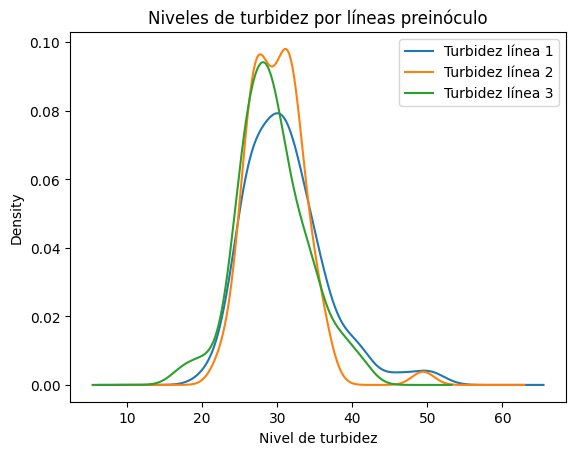

In [17]:
df_preinoculo[['Turbidez línea 1', 'Turbidez línea 2', 'Turbidez línea 3']].plot(kind='density')

plt.title("Niveles de turbidez por líneas preinóculo")
plt.xlabel("Nivel de turbidez")
plt.show()

Parece que los valores tienden a seguir una distribución "normal" como eje el valor `30` para todas las líneas de preinóculo.
Veamos si el `pH` tiene alguna relación con los valores de turbidez

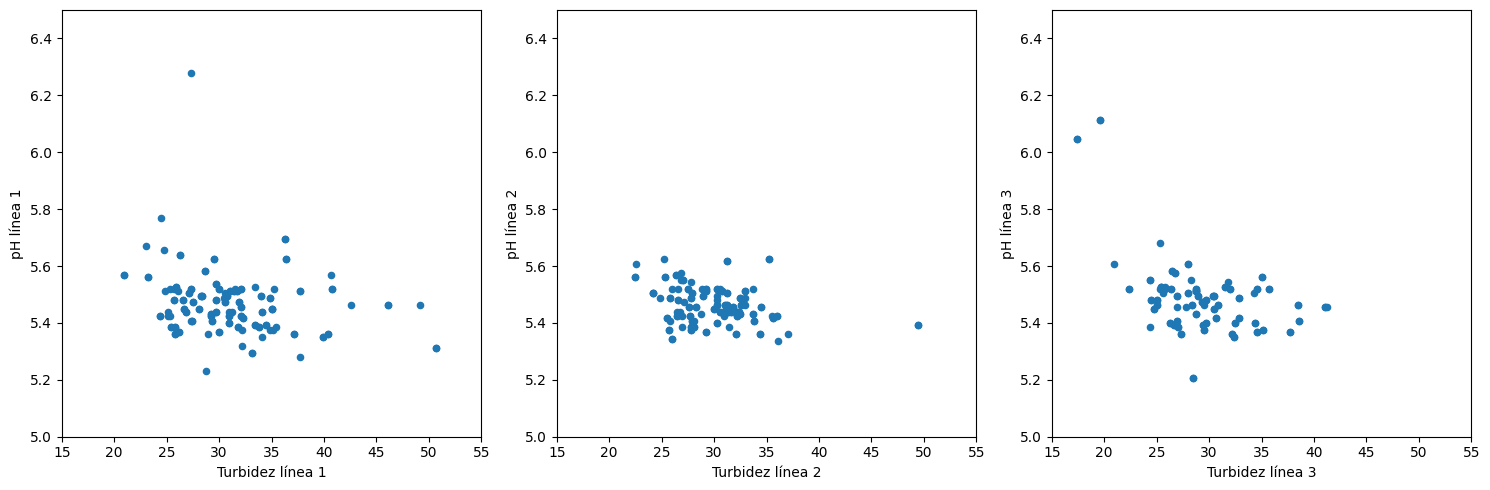

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    df_preinoculo.plot(kind='scatter', x=f'Turbidez línea {i+1}', y=f'pH línea {i+1}', ax=axes[i])
    # Misma escala 
    axes[i].set_xlim(15, 55) # min y max Turbidez
    axes[i].set_ylim(5, 6.5) # min y max Ph

plt.tight_layout()

La relación es casi constante dado que la nube de puntos se concentra en las mismas zonas para las tres líneas. Queda claro que valores de `pH` ideales se mantienen entre `5.4` y `5.6`. En cuanto a la turbidez la línea 2 parece ser la que menos desviación tiene entre las muestras, dado que tanto la línea 1 y 3 presentan nubes más dispersas junto con ciertos *outliers*

In [19]:
lineas = df_preinoculo.select_dtypes(include='int64')
lineas.sum() # Líneas más utilizadas para siguiente fase

Línea utilizada línea 1    125
Línea utilizada línea 2    109
Línea utilizada línea 3     56
dtype: int64

In [20]:
lineas.value_counts()

Línea utilizada línea 1  Línea utilizada línea 2  Línea utilizada línea 3
1                        1                        0                          80
                         0                        1                          35
0                        1                        1                          21
1                        0                        0                          10
0                        1                        0                           8
Name: count, dtype: int64

La combinación de las línea 1 y 2 es la más propensa a "pasar de fase".
La línea 1, sin duda es la más utilizada, mientras que la línea 3 la mas desechada

**NOTA**
Por otro lado vemos que hay un total de `18` lotes en los que tan solo se utiliza una de las líneas. Algo que contradice el enunciado del reto.

In [21]:
error_linea = df_preinoculo[df_preinoculo[['Línea utilizada línea 1', 'Línea utilizada línea 2', 'Línea utilizada línea 3']].sum(axis=1) == 1]

error_linea = error_linea[error_linea.isnull().any(axis=1)]

print("Total registros anómalos según las Líneas utilizada: 18")
print(f"Registros nulos en algunas de las columnas: {len(error_linea)} ")

error_linea

Total registros anómalos según las Líneas utilizada: 18
Registros nulos en algunas de las columnas: 15 


,LOTE,Fecha/hora inicio,Fecha/hora fin,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3,Línea utilizada línea 1,Línea utilizada línea 2,Línea utilizada línea 3
12,23035,2023-04-23 05:00:00,2023-03-24 07:30:00,5.520,5.520,NaN,25.68,26.56,NaN,1,0,0
19,23042,2023-05-29 05:00:00,2023-05-30 07:30:00,5.512,5.472,NaN,24.80,27.12,NaN,0,1,0
49,23075,2023-07-29 05:00:00,2023-07-31 07:15:00,5.464,NaN,NaN,42.56,NaN,NaN,1,0,0
51,23076,2023-07-30 05:00:00,2023-07-31 07:00:00,5.376,NaN,NaN,34.88,NaN,NaN,1,0,0
71,23097,2023-10-15 00:30:00,2023-10-16 07:30:00,5.352,NaN,NaN,34.08,NaN,NaN,1,0,0
78,23104,2023-10-29 00:30:00,2023-10-30 09:45:00,5.376,5.336,NaN,32.16,36.08,NaN,0,1,0
91,23120,2023-11-19 00:30:00,2023-11-20 07:45:00,5.320,5.384,NaN,32.16,31.44,NaN,1,0,0
92,23121,2023-11-19 00:30:00,2023-11-20 07:50:00,5.232,5.408,NaN,28.72,25.76,NaN,1,0,0
97,23131,2023-12-02 00:30:00,2023-12-03 06:55:00,5.376,5.424,NaN,35.12,35.52,NaN,1,0,0
107,24005,2024-01-18 00:30:00,2024-01-19 07:15:00,5.360,5.440,NaN,28.96,26.48,NaN,1,0,0


Vemos una estrecha relación entre valores perdidos de ph y turbidez con que tan solo se seleccione una de las líneas, cuando en realidad se deberían utilizar dos de ellas.

In [22]:
df_preinoculo['duracion_horas'] = (df_preinoculo['Fecha/hora fin'] - df_preinoculo['Fecha/hora inicio']).dt.total_seconds() / 3600

# Tras realizar la operacion aparecen algunos valores negativos -> MUY EXTRAÑO!! INSPECCIONAR LOTES EN OTRAS FASES
df_preinoculo[df_preinoculo['duracion_horas'] < 0 ]

,LOTE,Fecha/hora inicio,Fecha/hora fin,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3,Línea utilizada línea 1,Línea utilizada línea 2,Línea utilizada línea 3,duracion_horas
10,23033,2023-04-23 05:00:00,2023-03-24 13:30:00,5.448,5.456,5.392,28.08,28.24,29.44,1,0,1,-711.5
11,23034,2023-04-23 05:00:00,2023-03-24 13:30:00,5.448,5.456,5.392,28.08,28.24,29.44,1,0,1,-711.5
12,23035,2023-04-23 05:00:00,2023-03-24 07:30:00,5.520,5.520,NaN,25.68,26.56,NaN,1,0,0,-717.5


In [23]:
df_preinoculo[df_preinoculo['duracion_horas'] > 0 ]['duracion_horas'].describe()

count    151.000000
mean      33.256071
std       27.332647
min       25.000000
25%       26.791667
50%       30.750000
75%       31.166667
max      265.700000
Name: duracion_horas, dtype: float64

El 75% de los lotes necesitan al menos de unas 30 horas para obtener el preinóculo. Ahora bien, la desviación de la duración para realizar esta primera fase es muy grande, tendremos que investigar si hay otras variables que afecten a obtener una línea para ser utilizada.

##### Inóculo

In [25]:
df_inoculo = pd.read_excel('raw_data/Fases producción v02.xlsx', sheet_name='Inóculo', engine='openpyxl')
df_inoculo['LOTE'] = df_inoculo['LOTE'].apply(lambda l: int(l.replace('P','')) if type(l) != int else l)
df_inoculo.head(5)

,LOTE,ID bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo
0,23019,13171,NaT,NaT,NaN,NaN,32.80,134400000
1,23020,13171,NaT,NaT,NaN,NaN,32.80,134400000
2,23021,14618,NaT,NaT,NaN,NaN,27.84,115200000
3,23022,14618,NaT,NaT,NaN,NaN,27.84,115200000
4,23023,14618,2023-03-27 07:22:00,2023-03-28 07:29:00,155.2,18.24,31.68,106400000


In [26]:
df_inoculo.shape

(168, 8)

Algunos lotes quedan descartados al igual que pasaba con el preinóculo

In [27]:
df_inoculo = df_inoculo[df_inoculo['LOTE'].isin(LOTES)]
df_inoculo.shape

(159, 8)

In [28]:
df_inoculo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 0 to 167
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LOTE                      159 non-null    int64         
 1   ID bioreactor             159 non-null    int64         
 2   Fecha/hora inicio         155 non-null    datetime64[ns]
 3   Fecha/hora fin            155 non-null    datetime64[ns]
 4   Volumen de cultivo        155 non-null    float64       
 5   Turbidez inicio cultivo   153 non-null    float64       
 6   Turbidez final culttivo   159 non-null    float64       
 7   Viabilidad final cultivo  159 non-null    object        
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 11.2+ KB


La viabilidad del cultivo deberia representarse como número, seguramente haya algun registro con una cadena que pandas no sabe inferir, así que hay que definirlo manualmente

In [28]:
df_inoculo['Viabilidad final cultivo'] = pd.to_numeric(df_inoculo['Viabilidad final cultivo'], errors='coerce')

In [29]:
df_inoculo.isna().sum()

LOTE                        0
ID bioreactor               0
Fecha/hora inicio           4
Fecha/hora fin              4
Volumen de cultivo          4
Turbidez inicio cultivo     6
Turbidez final culttivo     0
Viabilidad final cultivo    1
dtype: int64

Hay pocos valores perdidos, podemos imputar algunos de ellos por la media y otros (las fechas) rescatarlos fijándonos en las tablas de preinoculo y cultivo final.

**NOTA** Incluso podríamos prescindir de ellos al principio por simpleza (el esfuerzo invertido para un par de registros no es efectivo en esta fase). Eso si, si optamos por esta opción debemos ser acordes a ello en el resto de conjuntos de datos (cuadrar lotes basicamente)

In [30]:
# Por simpleza a la hora de explorar
df_inoculo.dropna(inplace=True)
df_inoculo.shape

(152, 8)

Comprobamos que los datos proporcionados están correctos según el enunciado. Además el uso de los bioreactores por los lotes es bastante uniforme

> "Los frascos de preinóculo seleccionados se introducen, junto con medio de cultivo, en un biorreactor de pequeño tamaño (códigos 13171, 13172, 14618)"

In [31]:
ids_inoculo_biorreactor = df_inoculo['ID bioreactor'].unique()
print(f"Bioreactores utilizado {ids_inoculo_biorreactor}")
df_inoculo['ID bioreactor'].value_counts()

Bioreactores utilizado [14618 13172 13171]


ID bioreactor
13171    53
14618    50
13172    49
Name: count, dtype: int64

In [32]:
df_inoculo.describe(include=float)

,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo
count,152.000000,152.000000,152.000000,1.520000e+02
mean,151.977000,15.301579,25.894211,1.010264e+08
std,29.738796,1.728630,2.919894,2.506623e+07
min,79.200000,11.200000,17.680000,3.704000e+07
25%,160.000000,14.160000,24.240000,8.540000e+07
50%,164.000000,15.080000,25.840000,9.600000e+07
75%,167.200000,16.240000,27.640000,1.112000e+08
max,176.000000,21.520000,32.880000,2.520000e+08


Con la variable `Viabilidad final cultivo` pasa un poco lo mismo que con la turbidez, no contamos con una unidad de medida. Debemos ser nosotros los que fijemos un significado a los números. Por sentido común y simpleza, un valor alto mayor viabilidad y viceversa.

<Axes: ylabel='Density'>

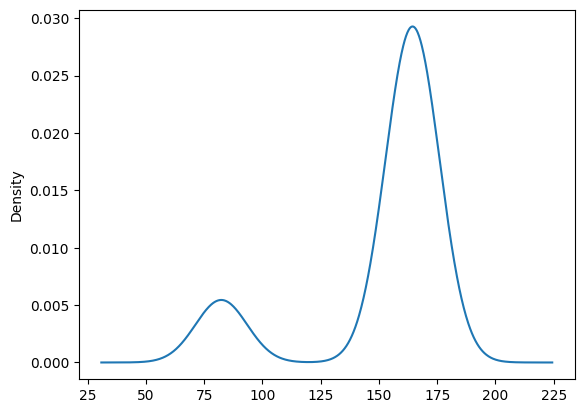

In [33]:
df_inoculo['Volumen de cultivo'].plot(kind='density')

El volumen de cultivo obtenido tras el inóculo se concentra entorno los `160` litros, aunque tambien se aprecia otra pequeña porción de lotes con una menor cantidad (deberemos ver que variables de los bioreactores crean este comportamiento)

In [34]:
df_inoculo['diferencia_turbidez'] = df_inoculo['Turbidez final culttivo'] - df_inoculo['Turbidez inicio cultivo']
df_inoculo['diferencia_turbidez'].describe()

count    152.000000
mean      10.592632
std        2.762632
min        1.840000
25%        9.360000
50%       10.520000
75%       12.080000
max       18.480000
Name: diferencia_turbidez, dtype: float64

La turbidez por lo general aumenta en 10 puntos en esta fase. Veamos si esta variable "ingeniada" tiene alguna correlación con la viabilidad del cultivo

In [35]:
float_columns = df_inoculo.select_dtypes(include='float')
float_columns.corr()

,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo,diferencia_turbidez
Volumen de cultivo,1.000000,0.050441,-0.038405,0.069182,-0.072153
Turbidez inicio cultivo,0.050441,1.000000,0.384534,-0.100817,-0.219295
Turbidez final culttivo,-0.038405,0.384534,1.000000,-0.022883,0.816315
Viabilidad final cultivo,0.069182,-0.100817,-0.022883,1.000000,0.038898
diferencia_turbidez,-0.072153,-0.219295,0.816315,0.038898,1.000000


In [36]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(float_columns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Heatmap of Float Columns')
# plt.show()

Parece ser la viabilidad guarda poca o nula relación con el resto de variables

In [37]:
df_inoculo['duracion_horas'] = (df_inoculo['Fecha/hora fin'] - df_inoculo['Fecha/hora inicio']).dt.total_seconds() / 3600
df_inoculo['duracion_horas'].describe()

count    152.000000
mean      24.477851
std        1.355539
min       22.083333
25%       23.829167
50%       24.083333
75%       24.891667
max       30.166667
Name: duracion_horas, dtype: float64

El proceso de inóculo tarda entre 20 y 30 horas en completarse, siendo unas 25 la "norma"

##### Cultivo final

In [38]:
df_cultivo = pd.read_excel('raw_data/Fases producción v02.xlsx', sheet_name='Cultivo final', engine='openpyxl')
df_cultivo.head(5)

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
0,23019,1,NaN,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.28,91.2,184000000,17825,NaN,NaN,1747.920,6.00
1,23020,1,NaN,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.80,91.2,181600000,14246,NaN,NaN,1676.160,6.56
2,23021,1,NaN,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.16,86.4,248000000,17825,NaN,NaN,1928.496,8.08
3,23022,1,NaN,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.48,83.2,229600000,12912,NaN,NaN,1782.800,5.92
4,23023,1,NaN,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.12,74.4,132800000,17825,26.56,20.88,1861.840,2.96


In [39]:
df_cultivo.shape

(152, 15)

In [40]:
df_cultivo = df_cultivo[df_cultivo['LOTE'].isin(LOTES)]
df_cultivo.shape

(151, 15)

In [41]:
df_cultivo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 0 to 151
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LOTE                          151 non-null    int64         
 1   Orden en el encadenado        151 non-null    int64         
 2   LOTE parental                 22 non-null     float64       
 3   ID Bioreactor                 151 non-null    int64         
 4   Fecha/hora inicio             151 non-null    datetime64[ns]
 5   Fecha/hora fin                151 non-null    datetime64[ns]
 6   Volumen de inóculo utilizado  146 non-null    float64       
 7   Turbidez inicio cultivo       151 non-null    float64       
 8   Turbidez fin cultivo          151 non-null    float64       
 9   Viabilidad final cultivo      151 non-null    object        
 10  ID Centrífuga                 151 non-null    int64         
 11  Centrifugación 1 turbidez     147 non

In [42]:
df_cultivo['Viabilidad final cultivo'] = pd.to_numeric(df_cultivo['Viabilidad final cultivo'], errors='coerce')

In [43]:
df_cultivo.isna().sum()

LOTE                              0
Orden en el encadenado            0
LOTE parental                   129
ID Bioreactor                     0
Fecha/hora inicio                 0
Fecha/hora fin                    0
Volumen de inóculo utilizado      5
Turbidez inicio cultivo           0
Turbidez fin cultivo              0
Viabilidad final cultivo          1
ID Centrífuga                     0
Centrifugación 1 turbidez         4
Centrifugación 2 turbidez         9
Producto 1                        0
Producto 2                        0
dtype: int64

Los valores nulos para `LOTE parental` no lo son como tal, es decir, en esta variable la ausencia de un valor significa que el lote no ha sido encadenado de uno previo. Esto se comprueba facilmente viendo que el número de valores "nulos" corresponde con un orden de encadenado igual a 1.

En cuanto al resto de variables:
- El volumen de inóculo se puede rescatar de la tabla anterior
- La turbidez de la centrifugación debería optarse por otros métodos como por ejemplo el valor medio

In [44]:
df_cultivo[df_cultivo['LOTE parental'].isna() & df_cultivo['Orden en el encadenado'] == 1].shape[0]

127

Realizando la comprobación resulta que hay dos registros perdidos de Lote Parental

In [45]:
df_cultivo[df_cultivo['LOTE parental'].isna() & ~df_cultivo['Orden en el encadenado'] == 1]

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
119,24016,2,NaN,14616,2024-01-22 11:20:00,2024-01-24 09:00:00,80.0,21.44,89.6,157600000.0,17825,34.00,NaN,1671.84,8.16
120,24017,2,NaN,14617,2024-01-22 11:00:00,2024-01-24 08:15:00,80.0,19.84,83.2,160000000.0,14246,28.56,24.32,1806.96,8.00


In [46]:
ids_cultivo_biorreactor = df_cultivo['ID Bioreactor'].unique() # [13169, 13170, 14614, 14615, 14616, 14617]
print(f"Bioreactores utilizado {ids_cultivo_biorreactor}")
df_cultivo['ID Bioreactor'].value_counts()

Bioreactores utilizado [14615 14616 13170 14614 13169 14617 13189]


ID Bioreactor
14616    34
14615    30
13170    29
14614    26
13169    22
14617     9
13189     1
Name: count, dtype: int64

Los bioreactores no coinciden con los del enunciado del reto: sobra el número 13189

Al contrario con el inóculo, para esta fase su uso no es tan balanceado

In [47]:
df_cultivo.describe(include=float)

,LOTE parental,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
count,22.000000,146.000000,151.000000,151.000000,1.500000e+02,147.000000,142.000000,151.000000,151.000000
mean,23571.818182,81.468493,18.027020,74.447682,1.703360e+08,30.065986,23.621972,1660.989605,6.130257
std,472.657697,2.252570,3.309846,8.962258,3.843024e+07,15.219392,17.266051,306.960238,1.407989
min,23085.000000,66.400000,12.560000,42.800000,7.040000e+07,21.280000,9.840000,526.400000,2.800000
25%,23112.250000,80.000000,16.400000,69.080000,1.482000e+08,26.400000,17.760000,1468.880000,5.160000
50%,23567.500000,81.600000,17.760000,74.400000,1.652000e+08,28.560000,20.760000,1676.160000,6.080000
75%,24034.750000,82.800000,18.760000,81.120000,1.926000e+08,30.520000,25.060000,1854.316000,7.120000
max,24051.000000,88.000000,44.400000,91.200000,3.696000e+08,168.800000,156.960000,2395.360000,9.200000


- La desviación en la producción de Producto 1 (nuestra variable objetivo) es considerablemente alta. Ahora entendemos el porque del reto. Los resultados de las fases no son estables, los máximos y mínimos son muy dispares
- La media de la viabilidad del cultivo aumenta ligeramente en esta fase respecto la anterior. 
- El volumen de inóculo utilizado es "casi" constante (mismo punto de partida)

In [48]:
df_cultivo['diferencia_turbidez'] = df_cultivo['Turbidez fin cultivo'] - df_cultivo['Turbidez inicio cultivo']
df_cultivo['diferencia_turbidez'].describe()

count    151.000000
mean      56.420662
std        9.180736
min       24.720000
25%       51.120000
50%       56.480000
75%       63.680000
max       73.920000
Name: diferencia_turbidez, dtype: float64

In [49]:
df_cultivo['diferencia_turbidez_centrifuga'] = df_cultivo['Centrifugación 2 turbidez'] - df_cultivo['Centrifugación 1 turbidez']
df_cultivo['diferencia_turbidez_centrifuga'].describe()

count    142.000000
mean      -6.467746
std        7.285305
min      -21.380000
25%      -11.100000
50%       -7.240000
75%       -3.080000
max       24.960000
Name: diferencia_turbidez_centrifuga, dtype: float64

Mientras que en los bioreactores la turbidez aumenta, con la centrifugación el producto se "aclara".
Notamos que la turbidez aumenta de forma más drástica que en el inóculo.

In [50]:
df_cultivo['duracion_horas'] = (df_cultivo['Fecha/hora fin'] - df_cultivo['Fecha/hora inicio']).dt.total_seconds() / 3600
df_cultivo['duracion_horas'].describe()

count    151.000000
mean      48.115342
std        1.955472
min       42.000000
25%       47.508333
50%       48.333333
75%       49.250000
max       53.750000
Name: duracion_horas, dtype: float64

La fase de cultibo ronda entre las 40 y 50 horas, lo cual es un incremento de 10 respecto al inóculo. "Haciendo la cuenta a la vieja", el total de horas necesario para completar todo el proceso hasta obtener el producto rondaría a grosso modo unas ~100 horas

#### Exploración Biorreactores

Dado que el formato de datos es el mismo para todos los bioreactores, cogeremos dos "aleatoriamente" como muestra. Un bioreactor pequeño y otro de los grandes para ver si hay alguna diferencia en las métricas obtenidas.

A diferencia de los datos explorados hasta ahora, estos son por naturaleza temporales. Esto debe tenerse en cuanta a la hora de mostras cualquier datos estadísticos

In [85]:
np.random.seed(seed)
bioreactor_choice = np.random.choice(ids_inoculo_biorreactor)

df_biorreactor_inoculo = pd.read_excel(f'raw_data/Biorreactor {bioreactor_choice}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_biorreactor_inoculo.head(5)

,13172_FERM0101.Agitation_PV,13172_FERM0101.Air_Sparge_PV,13172_FERM0101.Biocontainer_Pressure_PV,13172_FERM0101.DO_1_PV,13172_FERM0101.DO_2_PV,13172_FERM0101.Gas_Overlay_PV,13172_FERM0101.Load_Cell_Net_PV,13172_FERM0101.pH_1_PV,13172_FERM0101.pH_2_PV,13172_FERM0101.PUMP_1_PV,13172_FERM0101.PUMP_1_TOTAL,13172_FERM0101.PUMP_2_PV,13172_FERM0101.PUMP_2_TOTAL,13172_FERM0101.Single_Use_DO_PV,13172_FERM0101.Single_Use_pH_PV,13172_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2023-03-15 00:00:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.72,1.694073,-0.851783,0.0,4.96,0.0,0.0,875.360547,800.391992,19.376315
2023-03-15 00:15:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.72,1.694073,-0.851783,0.0,4.96,0.0,0.0,875.360547,800.391992,19.376001
2023-03-15 00:30:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.72,1.694073,-0.851783,0.0,4.96,0.0,0.0,875.360547,800.391992,19.272022
2023-03-15 00:45:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.72,1.694073,-0.851783,0.0,4.96,0.0,0.0,875.360547,800.391992,19.271780
2023-03-15 01:00:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.72,1.694073,-0.851783,0.0,4.96,0.0,0.0,875.360547,800.391992,19.272565


In [86]:
df_biorreactor_inoculo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52413 entries, 2023-03-15 00:00:00 to 2024-09-11 00:00:00
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   13172_FERM0101.Agitation_PV              48086 non-null  float64
 1   13172_FERM0101.Air_Sparge_PV             48086 non-null  float64
 2   13172_FERM0101.Biocontainer_Pressure_PV  48087 non-null  float64
 3   13172_FERM0101.DO_1_PV                   1178 non-null   float64
 4   13172_FERM0101.DO_2_PV                   48086 non-null  float64
 5   13172_FERM0101.Gas_Overlay_PV            48086 non-null  float64
 6   13172_FERM0101.Load_Cell_Net_PV          48087 non-null  float64
 7   13172_FERM0101.pH_1_PV                   48087 non-null  float64
 8   13172_FERM0101.pH_2_PV                   48087 non-null  float64
 9   13172_FERM0101.PUMP_1_PV                 48086 non-null  float64
 10  13172_FERM0

In [87]:
df_biorreactor_inoculo.isna().sum() / df_biorreactor_inoculo.shape[0]

13172_FERM0101.Agitation_PV                0.082556
13172_FERM0101.Air_Sparge_PV               0.082556
13172_FERM0101.Biocontainer_Pressure_PV    0.082537
13172_FERM0101.DO_1_PV                     0.977525
13172_FERM0101.DO_2_PV                     0.082556
13172_FERM0101.Gas_Overlay_PV              0.082556
13172_FERM0101.Load_Cell_Net_PV            0.082537
13172_FERM0101.pH_1_PV                     0.082537
13172_FERM0101.pH_2_PV                     0.082537
13172_FERM0101.PUMP_1_PV                   0.082556
13172_FERM0101.PUMP_1_TOTAL                0.082537
13172_FERM0101.PUMP_2_PV                   0.082556
13172_FERM0101.PUMP_2_TOTAL                0.082537
13172_FERM0101.Single_Use_DO_PV            0.082556
13172_FERM0101.Single_Use_pH_PV            0.082556
13172_FERM0101.Temperatura_PV              0.082537
dtype: float64

A pesar de haber un numero "grande" de registros perdidos, al ser un conjunto de tamaño considerable, los valores perdidos no cobran tanta importancia. Aun así, a primera vista parece que los números de registros nulos coinciden para casi todas las variables. Veamos si hay algun patrón oculto con unas simples consultas

In [88]:
all_nulls = df_biorreactor_inoculo[df_biorreactor_inoculo.isna().all(axis=1)]
all_nulls.shape

(4325, 16)

Hay un número considerable de muestras en las que no se ha registrado ninguna variable. Podemos suponer que en dichas horas, los biorreactores no están en funcionamiento o bien hay algun error en los sensores

In [89]:
df_biorreactor_inoculo[df_biorreactor_inoculo.isna().all(axis=1)].index.quarter.value_counts()

DateTime
3    2479
4    1046
1     797
2       3
Name: count, dtype: int64

Viendo las "cuartos de año" en los que todos las variables obtenidas son nulas, vemos que es mas habitual durante los meses de vacaciones (Julio, Agosto y Septiembre)

Son muchas de las variables que se miden, pero al igual que en las anteriores tablas, no tenemos puntos de referencia ni tampoco unidades de medida. Por lo que interpretar los datos estadísticos se vuelve algo de poca utilidad. Veamoslo con un ejemplo de lote "aleatorio" para ver como se comporta.

In [91]:
np.random.seed(seed)
lote_choice = np.random.choice(df_inoculo[df_inoculo['ID bioreactor'] == bioreactor_choice]['LOTE'])
lote_choice

24009

In [111]:
ini, fin = df_inoculo[df_inoculo['LOTE'] == lote_choice][['Fecha/hora inicio', 'Fecha/hora fin']].iloc[0]
print(ini)
print(fin)

2024-01-22 07:30:00
2024-01-23 06:45:00


In [120]:
df_bio_lote_choice = df_biorreactor_inoculo[(df_biorreactor_inoculo.index >= ini) & (df_biorreactor_inoculo.index <= fin)]
df_bio_lote_choice.sample(5, random_state=seed)

,13172_FERM0101.Agitation_PV,13172_FERM0101.Air_Sparge_PV,13172_FERM0101.Biocontainer_Pressure_PV,13172_FERM0101.DO_1_PV,13172_FERM0101.DO_2_PV,13172_FERM0101.Gas_Overlay_PV,13172_FERM0101.Load_Cell_Net_PV,13172_FERM0101.pH_1_PV,13172_FERM0101.pH_2_PV,13172_FERM0101.PUMP_1_PV,13172_FERM0101.PUMP_1_TOTAL,13172_FERM0101.PUMP_2_PV,13172_FERM0101.PUMP_2_TOTAL,13172_FERM0101.Single_Use_DO_PV,13172_FERM0101.Single_Use_pH_PV,13172_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2024-01-22 13:00:00,72.0,0.000000,3.131914,NaN,23.811433,3.999880,167.200000,-4.686229,5.935721,0.0,9.92,0.000000,0.0,26.101918,5.960000,29.223999
2024-01-23 05:15:00,72.0,10.977847,4.631971,NaN,20.031473,3.999148,165.679993,-4.686229,5.879150,0.0,9.92,3.813511,0.0,25.514638,5.951916,29.143994
2024-01-22 21:30:00,72.0,0.000000,2.049316,NaN,19.228456,3.999898,165.519995,-4.686229,5.903062,0.0,9.92,0.000000,0.0,20.902121,5.959845,29.159998
2024-01-22 23:30:00,72.0,0.000000,2.275816,NaN,23.346927,3.999922,165.279993,-4.686229,5.878859,0.0,9.92,0.585941,0.0,25.088108,5.944000,29.128003
2024-01-22 10:00:00,72.0,0.000000,3.234145,NaN,51.139835,3.999656,167.839990,-4.686229,5.927848,0.0,9.92,0.000000,0.0,53.247479,5.960102,29.536408


In [116]:
df_bio_lote_choice.describe()

,13172_FERM0101.Agitation_PV,13172_FERM0101.Air_Sparge_PV,13172_FERM0101.Biocontainer_Pressure_PV,13172_FERM0101.DO_1_PV,13172_FERM0101.DO_2_PV,13172_FERM0101.Gas_Overlay_PV,13172_FERM0101.Load_Cell_Net_PV,13172_FERM0101.pH_1_PV,13172_FERM0101.pH_2_PV,13172_FERM0101.PUMP_1_PV,13172_FERM0101.PUMP_1_TOTAL,13172_FERM0101.PUMP_2_PV,13172_FERM0101.PUMP_2_TOTAL,13172_FERM0101.Single_Use_DO_PV,13172_FERM0101.Single_Use_pH_PV,13172_FERM0101.Temperatura_PV
count,94.000000,94.000000,94.000000,0.0,94.000000,94.000000,94.000000,94.000000,94.000000,94.0,94.000000,94.000000,94.0,94.000000,94.000000,94.000000
mean,71.446809,1.617885,3.140548,NaN,26.096580,3.999966,166.388800,-4.556712,5.911013,0.0,9.713740,0.462490,0.0,28.195955,5.957275,29.444494
std,5.363390,4.325047,0.706767,NaN,16.411658,0.000332,1.281547,0.717314,0.031751,0.0,1.406425,1.095337,0.0,16.134938,0.009257,0.247043
min,20.000000,0.000000,1.875222,NaN,9.982952,3.999115,159.759998,-4.686229,5.871277,0.0,0.204996,0.000000,0.0,10.101448,5.943958,29.112144
25%,72.000000,0.000000,2.820432,NaN,16.467919,3.999749,165.459991,-4.686229,5.887024,0.0,9.920000,0.000000,0.0,18.667489,5.951937,29.208076
50%,72.000000,0.000000,3.129278,NaN,19.996719,3.999985,166.479993,-4.686229,5.919589,0.0,9.920000,0.000000,0.0,22.445416,5.960000,29.403964
75%,72.000000,0.000000,3.372885,NaN,25.056476,4.000222,167.279929,-4.686229,5.927848,0.0,9.920000,0.000000,0.0,27.563545,5.965904,29.664445
max,72.000000,15.996797,5.212317,NaN,80.154834,4.000748,169.605353,-0.506113,6.132291,0.0,9.920000,4.676138,0.0,80.093072,5.976000,29.871524


Tras el "cruce" de tablas, hemos extraído para un lote todas las mediciones para el biorreactor pequeño. De un vistazo se puede ver claramente que salvo una o dos variables todas son muy estables (no tienen apenas desviación). Esto tiene todo el sentido del mundo, ¿de qué nos serviría una aparato así, si no es capaz de mantener un entorno propicio para el cultivo según los parámetros que se configuren?

Por otro lado parece hay alguna variable con valores perdidos, por ejemplo las "PUMP" (adición de antiespumante y solución base) por los "ceros" en sus métricas y "DO_1_PV" (Presión parcial del oxígeno) que directamente arroja NaN

In [128]:
np.random.seed(seed)
bioreactor_choice = np.random.choice(ids_cultivo_biorreactor)

df_biorreactor_cultivo = pd.read_excel(f'raw_data/Biorreactor {bioreactor_choice}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_biorreactor_cultivo.head(5)

,14616_FERM0101.Agitation_PV,14616_FERM0101.Air_Sparge_PV,14616_FERM0101.Biocontainer_Pressure_PV,14616_FERM0101.DO_1_PV,14616_FERM0101.DO_2_PV,14616_FERM0101.Gas_Overlay_PV,14616_FERM0101.Load_Cell_Net_PV,14616_FERM0101.pH_1_PV,14616_FERM0101.pH_2_PV,14616_FERM0101.PUMP_1_PV,14616_FERM0101.PUMP_1_TOTAL,14616_FERM0101.PUMP_2_PV,14616_FERM0101.PUMP_2_TOTAL,14616_FERM0101.Single_Use_DO_PV,14616_FERM0101.Single_Use_pH_PV,14616_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2023-03-15 00:00:00,80.0,0.000000,0.715311,16.557993,0.0,3.999639,1652.800000,5.929625,-389.260962,0.0,39.679996,0.0,391.860913,17.361165,5.872,29.607996
2023-03-15 00:15:00,80.0,1.629763,0.795663,15.634378,0.0,4.000125,1652.800000,5.929625,-389.260962,0.0,39.679996,0.0,391.860913,16.468314,5.872,29.607996
2023-03-15 00:30:00,80.0,0.000000,0.844326,16.687202,0.0,4.000129,1652.807246,5.929625,-389.260962,0.0,39.679996,0.0,391.860913,17.516034,5.872,29.616003
2023-03-15 00:45:00,80.0,0.000000,0.755206,15.892802,0.0,3.999268,1652.800000,5.929625,-389.260962,0.0,39.679996,0.0,391.860913,16.595076,5.872,29.631995
2023-03-15 01:00:00,80.0,0.000000,0.755206,16.821199,0.0,3.999884,1652.800000,5.921457,-389.260962,0.0,39.679996,0.0,391.860913,17.754875,5.872,29.616193


In [129]:
df_biorreactor_cultivo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52413 entries, 2023-03-15 00:00:00 to 2024-09-11 00:00:00
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   14616_FERM0101.Agitation_PV              48054 non-null  float64
 1   14616_FERM0101.Air_Sparge_PV             48054 non-null  float64
 2   14616_FERM0101.Biocontainer_Pressure_PV  48054 non-null  float64
 3   14616_FERM0101.DO_1_PV                   48054 non-null  float64
 4   14616_FERM0101.DO_2_PV                   48054 non-null  float64
 5   14616_FERM0101.Gas_Overlay_PV            48054 non-null  float64
 6   14616_FERM0101.Load_Cell_Net_PV          48054 non-null  float64
 7   14616_FERM0101.pH_1_PV                   48054 non-null  float64
 8   14616_FERM0101.pH_2_PV                   48054 non-null  float64
 9   14616_FERM0101.PUMP_1_PV                 48054 non-null  float64
 10  14616_FERM0

In [130]:
df_biorreactor_cultivo.isna().sum() / df_biorreactor_inoculo.shape[0]

14616_FERM0101.Agitation_PV                0.083166
14616_FERM0101.Air_Sparge_PV               0.083166
14616_FERM0101.Biocontainer_Pressure_PV    0.083166
14616_FERM0101.DO_1_PV                     0.083166
14616_FERM0101.DO_2_PV                     0.083166
14616_FERM0101.Gas_Overlay_PV              0.083166
14616_FERM0101.Load_Cell_Net_PV            0.083166
14616_FERM0101.pH_1_PV                     0.083166
14616_FERM0101.pH_2_PV                     0.083166
14616_FERM0101.PUMP_1_PV                   0.083166
14616_FERM0101.PUMP_1_TOTAL                0.083166
14616_FERM0101.PUMP_2_PV                   0.083166
14616_FERM0101.PUMP_2_TOTAL                0.083166
14616_FERM0101.Single_Use_DO_PV            0.083166
14616_FERM0101.Single_Use_pH_PV            0.083166
14616_FERM0101.Temperatura_PV              0.083166
dtype: float64

In [131]:
all_nulls = df_biorreactor_cultivo[df_biorreactor_cultivo.isna().all(axis=1)]
all_nulls.shape

(4359, 16)

In [132]:
df_biorreactor_cultivo[df_biorreactor_cultivo.isna().all(axis=1)].index.quarter.value_counts()

DateTime
3    2395
4    1066
1     894
2       4
Name: count, dtype: int64

In [134]:
np.random.seed(seed)
lote_choice = np.random.choice(df_cultivo[df_cultivo['ID Bioreactor'] == bioreactor_choice]['LOTE'])
lote_choice

np.int64(24045)

In [136]:
ini, fin = df_cultivo[df_cultivo['LOTE'] == lote_choice][['Fecha/hora inicio', 'Fecha/hora fin']].iloc[0]
print(ini)
print(fin)

2024-03-12 07:25:00
2024-03-14 09:15:00


In [137]:
df_bio_lote_choice = df_biorreactor_inoculo[(df_biorreactor_inoculo.index >= ini) & (df_biorreactor_inoculo.index <= fin)]
df_bio_lote_choice.sample(5, random_state=seed)

,13172_FERM0101.Agitation_PV,13172_FERM0101.Air_Sparge_PV,13172_FERM0101.Biocontainer_Pressure_PV,13172_FERM0101.DO_1_PV,13172_FERM0101.DO_2_PV,13172_FERM0101.Gas_Overlay_PV,13172_FERM0101.Load_Cell_Net_PV,13172_FERM0101.pH_1_PV,13172_FERM0101.pH_2_PV,13172_FERM0101.PUMP_1_PV,13172_FERM0101.PUMP_1_TOTAL,13172_FERM0101.PUMP_2_PV,13172_FERM0101.PUMP_2_TOTAL,13172_FERM0101.Single_Use_DO_PV,13172_FERM0101.Single_Use_pH_PV,13172_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2024-03-13 02:00:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.96,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,16.176132
2024-03-12 10:00:00,0.0,0.0,480.0,NaN,0.0,0.0,-7.28,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,17.350321
2024-03-14 05:15:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.96,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,16.471997
2024-03-14 08:15:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.96,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,15.928003
2024-03-13 05:15:00,0.0,0.0,480.0,NaN,0.0,0.0,-6.96,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,16.254972


In [138]:
df_bio_lote_choice.describe()

,13172_FERM0101.Agitation_PV,13172_FERM0101.Air_Sparge_PV,13172_FERM0101.Biocontainer_Pressure_PV,13172_FERM0101.DO_1_PV,13172_FERM0101.DO_2_PV,13172_FERM0101.Gas_Overlay_PV,13172_FERM0101.Load_Cell_Net_PV,13172_FERM0101.pH_1_PV,13172_FERM0101.pH_2_PV,13172_FERM0101.PUMP_1_PV,13172_FERM0101.PUMP_1_TOTAL,13172_FERM0101.PUMP_2_PV,13172_FERM0101.PUMP_2_TOTAL,13172_FERM0101.Single_Use_DO_PV,13172_FERM0101.Single_Use_pH_PV,13172_FERM0101.Temperatura_PV
count,200.000000,200.000000,200.000000,0.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.0,200.000000,200.000000,200.000000,200.000000
mean,0.768575,0.079914,470.429460,NaN,0.645150,0.060003,-5.106585,-4.686229,1.391847,0.0,7.439927,0.0,2.753228,722.753288,784.322966,17.371586
std,6.669483,1.130028,67.162126,NaN,6.069985,0.487451,16.163367,0.000000,0.655387,0.0,0.001026,0.0,0.182346,98.954515,111.474327,1.776524
min,0.000000,0.000000,-0.087623,NaN,0.000000,0.000000,-7.855803,-4.686229,1.298498,0.0,7.425494,0.0,0.187360,15.312366,5.928000,15.777187
25%,0.000000,0.000000,480.000000,NaN,0.000000,0.000000,-7.040000,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,16.448536
50%,0.000000,0.000000,480.000000,NaN,0.000000,0.000000,-6.960000,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,17.215379
75%,0.000000,0.000000,480.000000,NaN,0.000000,0.000000,-6.960000,-4.686229,1.298498,0.0,7.439999,0.0,2.766121,736.844434,800.208008,17.951481
max,72.000000,15.981021,480.000000,NaN,81.650659,4.000316,166.879993,-4.686229,6.208184,0.0,7.439999,0.0,2.766121,736.844434,800.208008,29.856006


Tomando datos de uno de los bioreactores grandes volvemos a encontrarnos con el mismo escenario. No se aprecian diferencias notables a simple vista.

<Axes: xlabel='DateTime'>

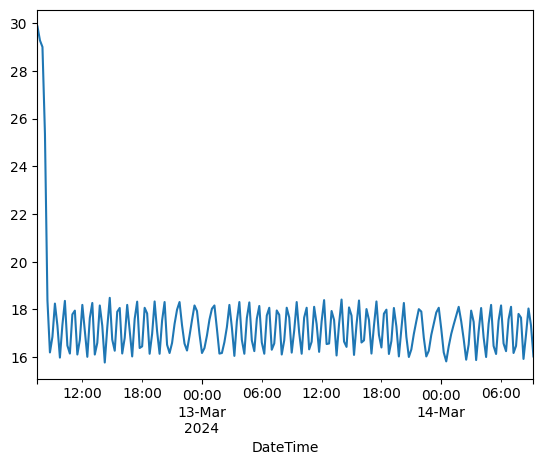

In [203]:
df_bio_lote_choice['13172_FERM0101.Temperatura_PV'].plot(kind='line') # Ejemplo de evolución de la variable

En casi todas las variables el valor inicial es bastante dispar, pero se estabiliza en seguida. Con la temperatura se puede ver la pequeña oscilación con el transcurso de la fase

Aspectos a tener en cuenta para la limpieza y transformación:

- Tener una tabla por bioreactor es poco eficiente, teniendo en cuenta que todos manejan las mismas variables. Lo que hay que hacer para simplificar las consultas es añadir una variable que indique el biorreactor que junto la fecha sea el indíce. Dicho de otra manera, para cada instante de tiempo, habrá tantos registros como bioreactores haya
- Relacionado con lo anterior, los nombres de las variables es bastante ofuscado, habría que trabajar con algo estándar (al igual que con el resto de tablas)
- Descartar las filas con todo nulos, no podemos recuperar dichos valores

##### Datos cinéticos de cada fase del producto

Todos los datos se encuentran en el mismo archivo, pero en hojas de Excel diferentes por lo que las cachearemos en *dataframes* diferentes para más comodidad

In [164]:
df_ipc_inoculo = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Inóculos', engine='openpyxl')
df_ipc_inoculo.head(5)

,Lote,Fecha,Turbidez,Viabilidad
0,23019,2023-03-21 06:30:00,32.80,134400000.0
1,23020,2023-03-21 06:30:00,32.80,134400000.0
2,23021,2023-03-22 06:30:00,27.84,115200000.0
3,23022,2023-03-22 06:30:00,27.84,115200000.0
4,23023,2023-03-27 07:30:00,18.24,10880000.0


In [165]:
df_ipc_inoculo.shape

(737, 4)

In [166]:
df_ipc_inoculo = df_ipc_inoculo[df_ipc_inoculo['Lote'].isin(LOTES)]
df_ipc_inoculo.shape

(656, 4)

In [167]:
df_ipc_inoculo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, 0 to 736
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Lote        656 non-null    object        
 1   Fecha       656 non-null    datetime64[ns]
 2   Turbidez    654 non-null    float64       
 3   Viabilidad  656 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 25.6+ KB


In [168]:
df_ipc_inoculo.describe(include=float)

,Turbidez,Viabilidad
count,654.000000,6.560000e+02
mean,20.028502,4.585787e+07
std,5.224630,4.473573e+07
min,11.200000,5.981333e+05
25%,15.620000,7.296667e+06
50%,18.240000,1.997333e+07
75%,24.700000,8.440000e+07
max,34.800000,1.669333e+08


In [157]:
df_ipc_inoculo['Lote'].value_counts()

Lote
23043    12
23036    10
23139     9
23138     9
23087     8
         ..
23045     2
23021     1
23020     1
23022     1
23019     1
Name: count, Length: 158, dtype: int64

No a todos los lotes se les han realizado la misma cantidad de controles. ¿Puede deberse al tiempo que tardan?

In [169]:
df_inoculo[df_inoculo['LOTE'] == 23043]

,LOTE,ID bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo,diferencia_turbidez,duracion_horas
25,23043,14618,2023-06-11 07:35:00,2023-06-12 07:35:00,84.0,13.2,24.24,87200000.0,11.04,24.0


In [174]:
df_inoculo[df_inoculo['LOTE'] == 23045] # 23021  23020 23022 23019 -> no existen ¿por qué?

,LOTE,ID bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo,diferencia_turbidez,duracion_horas
26,23045,14618,2023-06-11 07:35:00,2023-06-12 07:35:00,81.6,13.2,24.24,87200000.0,11.04,24.0


Ambas muestras tardaron lo mismo y el resto de variables son prácticamente idénticas

**NOTA** Algunos de los lotes de los datos de cinéticos no se encuentran en el conjunto de inóculo

In [178]:
df_ipc_inoculo['Fecha'].dt.hour.value_counts()

Fecha
7     168
6      99
8      96
12     47
20     40
16     38
9      36
11     31
15     24
19     23
10     20
13     12
18      7
17      6
14      5
21      4
Name: count, dtype: int64

Las mediciones se realizan por lo general durante las primeras horas de la mañana

In [179]:
df_ipc_cultivo = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Cultivos finales', engine='openpyxl')
df_ipc_cultivo.head(5)

,Lote,Fecha,Turbidez,Viabilidad,Glucosa g/L
0,23019,2023-03-21 07:30:00,17.28,8.333333e+06,1.744
1,23019,2023-03-21 11:00:00,17.28,1.397333e+07,1.968
2,23019,2023-03-21 14:00:00,18.4,1.688000e+07,1.92
3,23019,2023-03-21 18:00:00,19.76,2.474667e+07,1.88
4,23019,2023-03-22 07:00:00,39.12,1.000000e+08,1.568


In [181]:
df_ipc_cultivo.shape

(1911, 5)

In [182]:
df_ipc_cultivo = df_ipc_cultivo[df_ipc_cultivo['Lote'].isin(LOTES)]
df_ipc_cultivo.shape

(1721, 5)

In [190]:
df_ipc_cultivo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1721 entries, 0 to 1910
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Lote         1721 non-null   object        
 1   Fecha        1719 non-null   datetime64[ns]
 2   Turbidez     1713 non-null   float64       
 3   Viabilidad   1720 non-null   float64       
 4   Glucosa g/L  1405 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 80.7+ KB


No se infieren correctamente las columnas de coma flotante seguramente porque hay valores perdidos que pandas no sabe interpetar. Forzamos el "casteo"

In [191]:
df_ipc_cultivo['Turbidez'] = pd.to_numeric(df_ipc_cultivo['Turbidez'], errors='coerce')
df_ipc_cultivo['Glucosa g/L'] = pd.to_numeric(df_ipc_cultivo['Glucosa g/L'], errors='coerce')

In [192]:
df_ipc_cultivo.describe(include=float)

,Turbidez,Viabilidad,Glucosa g/L
count,1713.000000,1.720000e+03,1405.000000
mean,47.077343,9.953120e+07,1.336357
std,24.585495,1.183673e+08,0.583797
min,4.960000,8.160000e+05,0.000000
25%,20.240000,1.818667e+07,0.792000
50%,46.320000,9.813333e+07,1.448000
75%,70.560000,1.587333e+08,1.816000
max,104.800000,4.036267e+09,3.296000


La turbidez aumenta respecto la anterior fase y consigo la viabilidad, aunque en realidad la turbidez parece estar más relacionada con la glucosa

In [195]:
df_ipc_cultivo.select_dtypes(float).corr()

,Turbidez,Viabilidad,Glucosa g/L
Turbidez,1.000000,0.552517,-0.857791
Viabilidad,0.552517,1.000000,-0.425730
Glucosa g/L,-0.857791,-0.425730,1.000000


In [193]:
df_ipc_cultivo['Lote'].value_counts()

Lote
23082    16
23051    14
23038    14
23063    14
23092    14
         ..
24083     3
24084     3
24081     3
24019     3
24055     3
Name: count, Length: 205, dtype: int64

Ocurre lo mismo que antes, hay lotes que tienen más controles que otros

<Axes: title={'center': 'Evolución Glucosa'}>

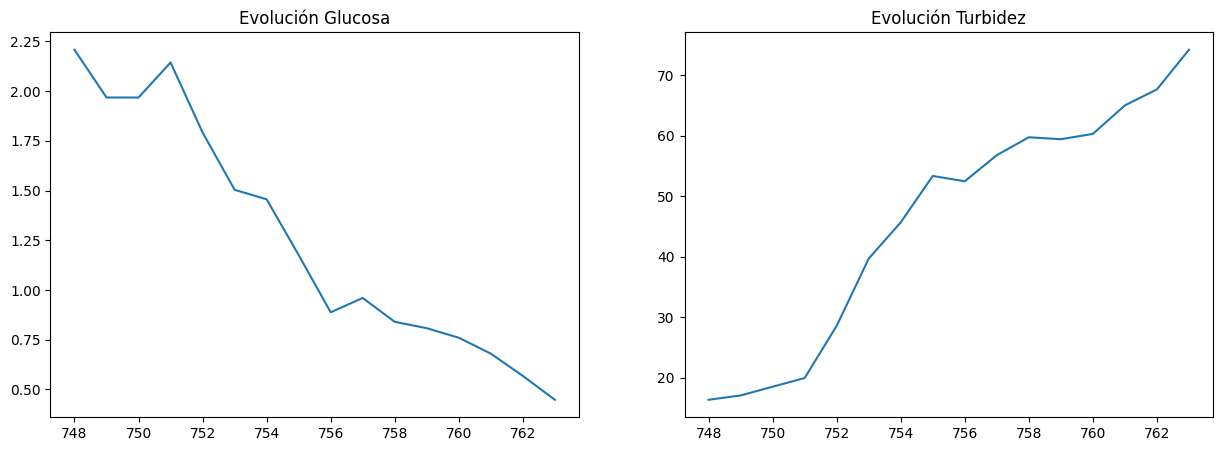

In [218]:
# mejorar  -> tomamos como ejemplo el lote con mas observaciones
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df_ipc_cultivo[df_ipc_cultivo['Lote'] == 23082]['Turbidez'].plot(kind='line', ax=axes[1], title="Evolución Turbidez")
df_ipc_cultivo[df_ipc_cultivo['Lote'] == 23082]['Glucosa g/L'].plot(kind='line', ax=axes[0], title="Evolución Glucosa")
# df_ipc_cultivo[df_ipc_cultivo['Lote'] == 23082]['Viabilidad'].plot(kind='line', ax=axes[2])

Con los gráficos se ve claramente que ambas variables son inversamente proporcionales

In [194]:
df_ipc_cultivo['Fecha'].dt.hour.value_counts()

Fecha
7.0     241
6.0     207
8.0     203
11.0    139
10.0    117
9.0     110
20.0    107
19.0    102
12.0    100
15.0     96
16.0     88
14.0     66
18.0     60
13.0     35
17.0     26
21.0     19
5.0       2
4.0       1
Name: count, dtype: int64

De nuevo, las mediciones de realizan generalmente a primeras horas de la mañana

In [23]:
df_ipc_centrifuga = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Centrifugación', engine='openpyxl')
df_ipc_centrifuga.head(5)

,Lote,Centrífuga,Centrifugada (1 o 2),Volumen centrifugado (L),Turbidez
0,23019,17825,1,200,26.8
1,23019,17825,1,400,26.32
2,23019,17825,1,600,28.16
3,23019,17825,1,800,28.08
4,23019,17825,1,1000,28.4


In [24]:
df_ipc_centrifuga.shape

(2426, 5)

In [25]:
df_ipc_centrifuga = df_ipc_centrifuga[df_ipc_centrifuga['Lote'].isin(LOTES)]
df_ipc_centrifuga.shape

(2209, 5)

In [26]:
df_ipc_centrifuga.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2209 entries, 0 to 2420
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Lote                      2209 non-null   object
 1   Centrífuga                2209 non-null   int64 
 2   Centrifugada (1 o 2)      2209 non-null   int64 
 3   Volumen centrifugado (L)  2209 non-null   int64 
 4   Turbidez                  2176 non-null   object
dtypes: int64(3), object(2)
memory usage: 103.5+ KB


No se carga correctamente la turbidez por la falta de algunos registros. Se fuerza el casteo

In [27]:
df_ipc_centrifuga['Turbidez'] = pd.to_numeric(df_ipc_centrifuga['Turbidez'], errors='coerce')

In [28]:
df_ipc_centrifuga[['Turbidez', 'Volumen centrifugado (L)']].describe()

,Turbidez,Volumen centrifugado (L)
count,2164.000000,2209.000000
mean,28.149030,836.803984
std,16.282145,638.533843
min,6.480000,100.000000
25%,23.360000,300.000000
50%,27.440000,600.000000
75%,30.160000,1400.000000
max,275.200000,2000.000000


Algo que llama mucho la atención es el hehco de que volumen de centrifugado es muy dispar. Veamos que ocurre con esta variable

In [29]:
df_ipc_centrifuga.value_counts()

Lote   Centrífuga  Centrifugada (1 o 2)  Volumen centrifugado (L)  Turbidez
23019  17825       1                     200                       26.80       1
23131  17825       1                     1000                      33.04       1
23132  12912       1                     1000                      31.68       1
                                         800                       32.00       1
                                         600                       31.28       1
                                                                              ..
23077  14246       2                     200                       21.20       1
                                         100                       17.04       1
                   1                     2000                      30.48       1
                                         1800                      29.84       1
24110  14246       2                     400                       27.60       1
Name: count, Length: 2164, dtype:

Al parecer un mismo lote se centrifuga varias veces y con volumenes diferentes en la misma centrifugadora

In [30]:
df_ipc_centrifuga['Centrífuga'].value_counts()

Centrífuga
14246    846
17825    773
12912    556
6379      19
14247     10
14146      5
Name: count, dtype: int64

Hay mas centrifugadores que las expuestas en el enunciado:

> "Las dos centrifugaciones se realizan en la misma centrífuga. Los códigos de las centrífugas son: 12912, 14246, 17825"

¿Nos tenemos que quedar unicamente con las tres que mas se usan? (Son las que coinciden con el enunciado del reto)

In [31]:
ids_centrifugadora = [12912, 14246, 17825]

In [32]:
df_ipc_centrifuga['Centrifugada (1 o 2)'].value_counts()

Centrifugada (1 o 2)
1    1535
2     674
Name: count, dtype: int64

In [33]:
df_ipc_centrifuga.groupby(by='Lote').agg(
    {'Volumen centrifugado (L)': ['sum', 'max', 'min', list], 
     'Turbidez': ['mean', 'std'], 
     'Centrifugada (1 o 2)': [
         ('count1', lambda x: (x == 1).sum()), 
         ('count2',lambda x: (x == 2).sum())
        ]
    })

Volumen centrifugado (L)             \
                           sum   max  min   
Lote                                        
23019                    12000  2000  100   
23020                    12000  2000  100   
23021                    12000  2000  100   
23022                    12000  2000  100   
23023                    12000  2000  100   
...                        ...   ...  ...   
24106                     3700  2000  100   
24107                     3700  2000  100   
24108                     3700  2000  100   
24109                     3700  2000  100   
24110                     3700  2000  100   

                                                           Turbidez            \
                                                    list       mean       std   
Lote                                                                            
23019  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...  26.017143  3.252065   
23020  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...  24.011429  7.357448   
23021  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...  26.291429  4.678525   
23022  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...  21.782857  7.651835   
23023  [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1...  24.977143  2.720394   
...                                                  ...        ...       ...   
24106                        [200, 1000, 2000, 100, 400]  29.856000  3.199200   
24107                        [200, 1000, 2000, 100, 400]  26.288000  2.781424   
24108                        [200, 1000, 2000, 100, 400]  24.016000  7.869211   
24109                        [200, 1000, 2000, 100, 400]  30.480000  1.723253   
24110                        [200, 1000, 2000, 100, 400]  31.856000  3.717375   

      Centrifugada (1 o 2)         
                    count1 count2  
Lote                               
23019                   10      4  
23020                   10      4  
23021                   10      4  
23022                   10      4  
23023                   10      4  
...                    ...    ...  
24106                    3      2  
24107                    3      2  
24108                    3      2  
24109                    3      2  
24110                    3      2  

[206 rows x 8 columns]

- Los volumenes de centrifugado son siempre estándar: múltiplos de 200
- La turbidez entre los diferentes volumenes varía ligeramente 
- Es evidente que los volumenes de centrifugado son mayores en la fase 1, quedando menor volumen para la segunda centrifugación (fijándonos en el orden de las listas de volumenes)

##### Variables centrifugadoras

Al igual que los biorreactores, las centrifugadores también disponen de un conjunto de mediciones a lo largo del tiempo. Seleccionaremos uno de las tablas al "azar" dado que todos siguen la misma estructura

In [9]:
np.random.seed(seed)
centrifugadora_choice = np.random.choice(ids_centrifugadora)


df_centrifugadora = pd.read_excel(f'raw_data/Centrífuga {centrifugadora_choice}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_centrifugadora.head(5)

,14246_CTF0101.EN_Parcial,14246_CTF0101.EN_Total,14246_D01780551.PV,14246_D01906041.PV,14246_D01916047.PV,14246_D01916503.PV,14246_D01919022.PV
DateTime,,,,,,,
2023-03-15 00:00:00,0.0,0.0,100.0,0.0,0.426557,NaN,0.0
2023-03-15 00:15:00,0.0,0.0,100.0,0.0,0.425116,NaN,0.0
2023-03-15 00:30:00,0.0,0.0,100.0,0.0,0.425405,NaN,0.0
2023-03-15 00:45:00,0.0,0.0,100.0,0.0,0.425408,NaN,0.0
2023-03-15 01:00:00,0.0,0.0,100.0,0.0,0.426263,NaN,0.0


In [11]:
df_centrifugadora.shape

(52413, 7)

In [21]:
df_centrifugadora.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52413 entries, 2023-03-15 00:00:00 to 2024-09-11 00:00:00
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   14246_CTF0101.EN_Parcial  51828 non-null  float64
 1   14246_CTF0101.EN_Total    51828 non-null  float64
 2   14246_D01780551.PV        52368 non-null  float64
 3   14246_D01906041.PV        52368 non-null  float64
 4   14246_D01916047.PV        52368 non-null  float64
 5   14246_D01916503.PV        37518 non-null  float64
 6   14246_D01919022.PV        52368 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [22]:
df_centrifugadora.isna().sum()

14246_CTF0101.EN_Parcial      585
14246_CTF0101.EN_Total        585
14246_D01780551.PV             45
14246_D01906041.PV             45
14246_D01916047.PV             45
14246_D01916503.PV          14895
14246_D01919022.PV             45
dtype: int64

Nos encontramos con valores perdidos en todas las columnas, pero hay una que llama más la atención que otras `D01916503.PV` (Presión del agua de maniobra) que faltan muchos más registros en comparación con el resto

Para ver la evolución de las variables en el tiempo, cogeremos un lote al "azar" como muestra para ver como se comportan y entender cómo se pueden explotar estos datos. Primero, necesitaremos los horarios de las centrifugadoras

In [40]:
df_horario_centrifuga = pd.read_excel('raw_data/Horas inicio fin centrífugas.xlsx',parse_dates=["DATEVALUE"] , engine='openpyxl')
df_horario_centrifuga.head(5)

,EQUIPO,Operación,Orden,DATEVALUE
0,14246,Centrifugació 1 ini,10005144,2023-05-26 13:45:41
1,14246,Centrifugació 1 fi,10005144,2023-05-26 15:26:57
2,14246,Centrifugació 2 ini,10005144,2023-05-26 16:56:30
3,14246,Centrifugació 2 fi,10005144,2023-05-26 18:18:12
4,14246,Centrifugació 1 ini,10005176,2023-07-07 11:53:24


In [41]:
df_horario_centrifuga.shape

(984, 4)

In [42]:
df_horario_centrifuga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   EQUIPO     984 non-null    int64         
 1   Operación  984 non-null    object        
 2   Orden      984 non-null    int64         
 3   DATEVALUE  984 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 30.9+ KB


Esta tabla tiene ciertas peculiaridades. A diferencia del resto, su índice no es de tipo `datetime`. Más bien se basa en los "eventos" que ocurren: inicio y fin de centrifugación. Esto complica en gran parte su manejo y también cruce con otras tablas para obtener información.

- Las filas deben a pasar a ser columnas (pivot) donde las cuatro operaciones: "Centri 1 ini" , "Centri 1 fin", "Centri 2 ini", "Centri 2 fin" pasen a ser columnas/variables de tipo temporal con los datos de la columna `DATEVALUE`
- Aqui se trabaja con ordenes en lugar de lotes como en el resto de conjuntos. Habría que añadir la correspondencia para no tener que realizar siempre `join` con la tabla de información básica inicial proporcionada
- La columna `EQUIPO` debe ser renombrada para que sea comun un nombre comun con las otras tablas

Para poder realizar la tarea de exploración, haremos las operaciones manualmente por agilidad

In [44]:
df_horario_centrifuga[df_horario_centrifuga['EQUIPO'] == centrifugadora_choice][0:2]

,EQUIPO,Operación,Orden,DATEVALUE
0,14246,Centrifugació 1 ini,10005144,2023-05-26 13:45:41
1,14246,Centrifugació 1 fi,10005144,2023-05-26 15:26:57


In [46]:
ini, fin = df_horario_centrifuga[df_horario_centrifuga['EQUIPO'] == centrifugadora_choice][0:2]['DATEVALUE'].to_list()
print(ini)
print(fin)

2023-05-26 13:45:41
2023-05-26 15:26:57


In [47]:
np.random.seed(seed)
lotes_centrifugadora = df_ipc_centrifuga[df_ipc_centrifuga['Centrífuga'] == centrifugadora_choice]['Lote'].to_list()
lote_choice = np.random.choice(lotes_centrifugadora)
lote_choice

np.int64(23088)

In [48]:
df_ipc_centrifuga[df_ipc_centrifuga['Lote'] == lote_choice]

,Lote,Centrífuga,Centrifugada (1 o 2),Volumen centrifugado (L),Turbidez
994,23088,14246,1,200,32.32
995,23088,14246,1,400,31.12
996,23088,14246,1,600,32.48
997,23088,14246,1,800,30.80
998,23088,14246,1,1000,31.28
999,23088,14246,1,1200,31.68
1000,23088,14246,1,1400,31.20
1001,23088,14246,1,1600,32.40
1002,23088,14246,1,1800,31.68
1003,23088,14246,1,2000,31.76


In [52]:
df_centrifugadora_sample = df_centrifugadora[(df_centrifugadora.index >= ini) & (df_centrifugadora.index <= fin)]
df_centrifugadora_sample

,14246_CTF0101.EN_Parcial,14246_CTF0101.EN_Total,14246_D01780551.PV,14246_D01906041.PV,14246_D01916047.PV,14246_D01916503.PV,14246_D01919022.PV
DateTime,,,,,,,
2023-05-26 14:00:00,0.0,0.0,27.377303,508.939415,3.228658,NaN,6679.213381
2023-05-26 14:15:00,0.0,0.0,26.506624,504.443654,3.176922,NaN,6678.545603
2023-05-26 14:30:00,0.0,0.0,27.124602,500.443737,3.252317,NaN,6679.013188
2023-05-26 14:45:00,0.0,0.0,26.306660,497.017829,3.130083,NaN,6679.182390
2023-05-26 15:00:00,0.0,0.0,27.201634,497.076719,3.201098,NaN,6677.497421
2023-05-26 15:15:00,0.0,0.0,27.641188,490.997559,3.193712,NaN,6676.607707


In [54]:
df_centrifugadora_sample.describe()

,14246_CTF0101.EN_Parcial,14246_CTF0101.EN_Total,14246_D01780551.PV,14246_D01906041.PV,14246_D01916047.PV,14246_D01916503.PV,14246_D01919022.PV
count,6.0,6.0,6.000000,6.000000,6.000000,0.0,6.000000
mean,0.0,0.0,27.026335,499.819819,3.197132,NaN,6678.343282
std,0.0,0.0,0.515682,6.295144,0.042357,NaN,1.065700
min,0.0,0.0,26.306660,490.997559,3.130083,NaN,6676.607707
25%,0.0,0.0,26.661119,497.032551,3.181119,NaN,6677.759467
50%,0.0,0.0,27.163118,498.760228,3.197405,NaN,6678.779395
75%,0.0,0.0,27.333386,503.443675,3.221768,NaN,6679.140089
max,0.0,0.0,27.641188,508.939415,3.252317,NaN,6679.213381


En el período seleccionado vemos un comportamiento similar a las mediciones de los biorreactores:
- Columnas con valores "nulos", aparte de la columna ya identificado con valores perdidos
- Poca varianza en las mediciones, no hay presencia de valores dispares (misma suposición de mantener un entorno estable)

##### Materiales y condiciones almacenes

In [87]:
df_componentes = pd.read_excel('raw_data/Movimientos componentes.xlsx', engine='openpyxl')
df_componentes.head(5)

,Lote,Material,Lote interno,Lote Proveedor,Qty,Fecha recepción,Fecha traslado
0,23019,100001,737133,AM1798471,72.0,2023-01-12 00:00:00,2023-03-22 00:00:00
1,23019,100002,676155,K53821835,72.0,2022-03-07 00:00:00,2023-03-15 00:00:00
2,23019,100003,636590,0005065337,4800.0,2021-08-27 00:00:00,2023-03-13 00:00:00
3,23019,100004,655968,2414150,320.0,2021-11-25 00:00:00,2023-03-10 00:00:00
4,23019,100005,723171,M3889,96.0,2022-11-04 00:00:00,2023-03-03 00:00:00


In [88]:
df_componentes.shape

(5024, 7)

In [89]:
df_componentes = df_componentes[df_componentes['Lote'].isin(LOTES)] # & (df_componentes['Material'] == 123456)

In [90]:
df_componentes.shape

(4659, 7)

Filtrando por el material de estudio de la tabla básica inicial, no obtenemos ningun resultado. Con esto suponemos que la semántica de `Material` es diferente

In [92]:
df_componentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4659 entries, 0 to 5023
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Lote             4659 non-null   int64  
 1   Material         4659 non-null   int64  
 2   Lote interno     4659 non-null   int64  
 3   Lote Proveedor   4659 non-null   object 
 4   Qty              4659 non-null   float64
 5   Fecha recepción  4659 non-null   object 
 6   Fecha traslado   4659 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 291.2+ KB


Sin valores nulos, pero la inferencia de los tipo de datos temporales no ha funcionado automáticamente

In [93]:
df_componentes['Fecha recepción'] = pd.to_datetime(df_componentes['Fecha recepción'])
df_componentes['Fecha traslado'] = pd.to_datetime(df_componentes['Fecha traslado'])

In [94]:
df_componentes.isna().sum()

Lote               0
Material           0
Lote interno       0
Lote Proveedor     0
Qty                0
Fecha recepción    0
Fecha traslado     0
dtype: int64

Creamos un campo calculado para ver cual es el tiempo medio que pasan los lotes en el almacen principal antes de pasar al de producción

In [97]:
df_componentes['duracion_entre_almacenes'] = (df_componentes['Fecha traslado'] - df_componentes['Fecha recepción']).dt.days

In [103]:
df_componentes[['Qty', 'duracion_entre_almacenes']].describe()

,Qty,duracion_entre_almacenes
count,4659.000000,4659.000000
mean,1636.611052,153.648208
std,2728.765576,179.222326
min,-8352.000000,0.000000
25%,68.400000,28.000000
50%,144.896000,95.000000
75%,2046.720000,177.000000
max,9600.000000,875.000000


Existe una gran disparidad tanto en la cantidad de material entregado como en la duración de este en el almacen principal. Deberíamos fijarnos en algun lote para poder extraer información más concreta

**NOTA**
- Hay cantidades negativas !!!

In [144]:
df_componentes[['Fecha traslado', 'Fecha recepción']].min()

Fecha traslado    1970-01-01 00:00:00.000045261
Fecha recepción   1970-01-01 00:00:00.000044869
dtype: datetime64[ns]

¿Hay material en almacen desde hace 50 años?

In [145]:
df_componentes[['Fecha traslado', 'Fecha recepción']].max()

Fecha traslado    2024-04-15
Fecha recepción   2024-04-10
dtype: datetime64[ns]

In [119]:
df_componentes.groupby(by='Lote').agg({'Lote Proveedor': ['nunique'], 'Lote interno': ['nunique'], 'Material': ['nunique'], 'Qty': ['min', 'max'], 'duracion_entre_almacenes': ['min', 'max']})

Lote Proveedor Lote interno Material     Qty          \
             nunique      nunique  nunique     min     max   
Lote                                                         
23019             12           12       12   7.248  8352.0   
23020             13           13       12   7.248  8352.0   
23021             13           13       12   7.248  8352.0   
23022             13           13       12   7.248  8352.0   
23024             13           13       12   7.160  8352.0   
...              ...          ...      ...     ...     ...   
24106             12           13       12  57.992  8352.0   
24107             12           13       12  57.600  8352.0   
24108             13           13       12  57.808  8352.0   
24109             12           12       12  57.600  8360.0   
24110             12           13       12  57.824  8360.0   

      duracion_entre_almacenes           
                          mean min  max  
Lote                                     
23019               215.440000   2  563  
23020               225.500000   2  563  
23021               215.720000   2  563  
23022               215.720000   2  563  
23024               229.384615   2  536  
...                        ...  ..  ...  
24106                 0.000000   0    0  
24107                 0.000000   0    0  
24108                 0.000000   0    0  
24109                 0.000000   0    0  
24110                 0.000000   0    0  

[183 rows x 8 columns]

- No se ve diferencia entre lo que es un lote proveedor y un lote interno, parece ser que son lo mismo (relación uno a uno), salvo que se representan con identificadores diferentes
- Todos los lotes fabricados se conforman por varias "entregas" de diferentes materiales por parte del proveedor. A primera vista parece que siempre son necesarios 12 materiales diferentes para producir el producto final

In [128]:
df_componentes.groupby(by=['Lote','Material']).agg({'Lote Proveedor': ['nunique'], 'Qty': list, 'duracion_entre_almacenes': [list]})

Lote Proveedor                              Qty  \
                      nunique                             list   
Lote  Material                                                   
23019 100001                1  [72.0, 57.6, 7.248000000000001]   
      100002                1           [72.0, 385.984, 48.32]   
      100003                1                         [4800.0]   
      100004                1                    [320.0, 80.0]   
      100005                1                    [96.0, 12.08]   
...                       ...                              ...   
24110 100008                1                         [145.08]   
      100009                1                         [7680.0]   
      100010                1                           [96.0]   
      100011                1                         [3200.0]   
      100012                1                         [7872.0]   

               duracion_entre_almacenes  
                                   list  
Lote  Material                           
23019 100001               [69, 49, 49]  
      100002            [373, 373, 373]  
      100003                      [563]  
      100004                 [470, 470]  
      100005                 [119, 119]  
...                                 ...  
24110 100008                        [0]  
      100009                        [0]  
      100010                        [0]  
      100011                        [0]  
      100012                        [0]  

[2196 rows x 3 columns]

- En un mismo lote del proveedor, vienen diferentes cantidades de material. Suponemos que es el tipo de envasado lo que causa esto
- Las diferentes cantidades pueden ser llevadas al almacen de producción en diferentes días (no van todas juntas)

Por último, nos queda explorar el otro conjunto que muestra datos temporales, esta vez de las condiciones en las que se encuentran los materiales en los almacenes

In [130]:
df_temp_hum = pd.read_excel('raw_data/Temperaturas y humedades.xlsx', parse_dates=True, index_col='DateTime', sheet_name='Datos', engine='openpyxl')
df_temp_hum.head(5)

,06299_TI1302.PV,06299_MI1302.PV,06299_TI1402.PV,06299_MI1402.PV,07633_TI0601.PV,07633_HI0101.PV,07781_TI1501.PV,07781_MI1501.PV
DateTime,,,,,,,,
2023-03-15 00:00:00,23.931585,34.801435,22.854169,35.223422,18.901909,35.290073,20.247395,48.842590
2023-03-15 01:00:00,23.747978,34.404315,21.562853,36.619001,18.786171,35.456451,20.247395,48.712383
2023-03-15 02:00:00,23.615734,33.789356,22.580972,33.759999,18.453837,35.040508,20.133463,48.571323
2023-03-15 03:00:00,19.906570,38.749275,19.631797,38.061402,18.422140,33.698639,20.133463,48.296440
2023-03-15 04:00:00,19.037770,39.895817,19.551820,37.560487,18.726911,32.628036,19.997829,48.166233


In [131]:
df_temp_hum.shape

(13104, 8)

In [133]:
df_temp_hum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13104 entries, 2023-03-15 00:00:00 to 2024-09-11 00:00:00
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   06299_TI1302.PV  13101 non-null  float64
 1   06299_MI1302.PV  13100 non-null  float64
 2   06299_TI1402.PV  13101 non-null  float64
 3   06299_MI1402.PV  13101 non-null  float64
 4   07633_TI0601.PV  13103 non-null  float64
 5   07633_HI0101.PV  13103 non-null  float64
 6   07781_TI1501.PV  13099 non-null  float64
 7   07781_MI1501.PV  13100 non-null  float64
dtypes: float64(8)
memory usage: 921.4 KB


In [134]:
df_temp_hum.isna().sum()

06299_TI1302.PV    3
06299_MI1302.PV    4
06299_TI1402.PV    3
06299_MI1402.PV    3
07633_TI0601.PV    1
07633_HI0101.PV    1
07781_TI1501.PV    5
07781_MI1501.PV    4
dtype: int64

Muy pocos valores perdidos, podría prescindirse directamente de ellos

In [132]:
df_temp_hum.describe()

,06299_TI1302.PV,06299_MI1302.PV,06299_TI1402.PV,06299_MI1402.PV,07633_TI0601.PV,07633_HI0101.PV,07781_TI1501.PV,07781_MI1501.PV
count,13101.000000,13100.000000,13101.000000,13101.000000,13103.000000,13103.000000,13099.000000,13100.000000
mean,19.945667,59.758269,21.225364,52.883192,21.153857,44.195312,20.309929,47.745456
std,4.208069,15.538909,3.348947,14.166843,1.252494,6.070702,0.487869,4.930274
min,11.207923,17.899105,14.017152,16.216573,17.462379,20.525896,19.399305,25.625723
25%,18.338572,46.750788,19.103062,40.836264,20.225693,40.960716,20.083971,45.382350
50%,19.634083,61.750085,20.537432,53.287868,21.137154,44.865162,20.288324,49.348072
75%,21.669557,71.920933,22.182369,66.390607,22.037758,48.216869,20.426504,51.388938
max,39.573353,93.908478,38.340405,86.951979,26.645691,60.445585,26.199074,59.357064


- Los rangos de temperatura y humedad están acotados en un rango bastante amplios para algunas de las salas, sobretodo en las que se encuentra la maquinaria (biorreactores y centrifugadores 1302 y 1402). Suponemos que el funcionamiento de las máquinas provoca dicho efecto
- Al contrario, ambos almacenes presentan menor variacion de ambos parámetros

Veamos la evolución de las variables en el tiempo para un lote concreto

In [149]:
df_componentes[df_componentes['duracion_entre_almacenes'] > 0].loc[0]

Lote                                      23019
Material                                 100001
Lote interno                             737133
Lote Proveedor                        AM1798471
Qty                                        72.0
Fecha recepción             2023-01-12 00:00:00
Fecha traslado              2023-03-22 00:00:00
duracion_entre_almacenes                     69
Name: 0, dtype: object

In [153]:
ini, fin = df_componentes[df_componentes['duracion_entre_almacenes'] > 0].loc[0][['Fecha recepción', 'Fecha traslado']]
print(ini)
print(fin)

2023-01-12 00:00:00
2023-03-22 00:00:00


In [155]:
df_temp_hum_sample = df_temp_hum[(df_temp_hum.index >= ini) & (df_temp_hum.index <= fin)]
df_temp_hum_sample.head(5)

,06299_TI1302.PV,06299_MI1302.PV,06299_TI1402.PV,06299_MI1402.PV,07633_TI0601.PV,07633_HI0101.PV,07781_TI1501.PV,07781_MI1501.PV
DateTime,,,,,,,,
2023-03-15 00:00:00,23.931585,34.801435,22.854169,35.223422,18.901909,35.290073,20.247395,48.842590
2023-03-15 01:00:00,23.747978,34.404315,21.562853,36.619001,18.786171,35.456451,20.247395,48.712383
2023-03-15 02:00:00,23.615734,33.789356,22.580972,33.759999,18.453837,35.040508,20.133463,48.571323
2023-03-15 03:00:00,19.906570,38.749275,19.631797,38.061402,18.422140,33.698639,20.133463,48.296440
2023-03-15 04:00:00,19.037770,39.895817,19.551820,37.560487,18.726911,32.628036,19.997829,48.166233


<Axes: title={'center': 'Evolución temperatura almacen principal'}, xlabel='Fecha', ylabel='Temperatura'>

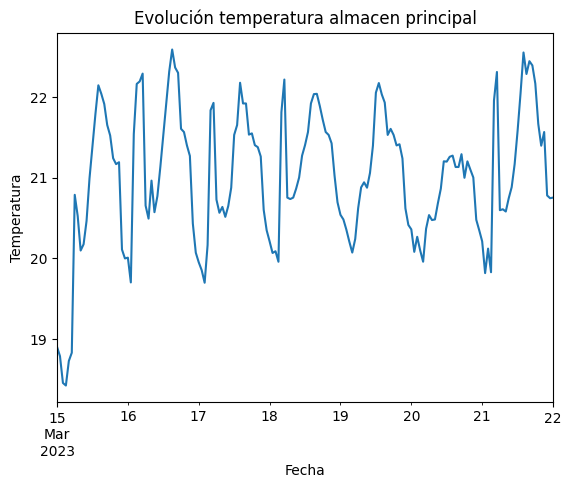

In [160]:
df_temp_hum_sample['07633_TI0601.PV'].plot(title='Evolución temperatura almacen principal', xlabel='Fecha', ylabel='Temperatura')

A pesar de oscilar a lo largo del día, tan solo se trata de +- 2 grados, lo cual es un entorno bastante controlado

<Axes: title={'center': 'Evolución humedad almacen principal'}, xlabel='Fecha', ylabel='Humedad'>

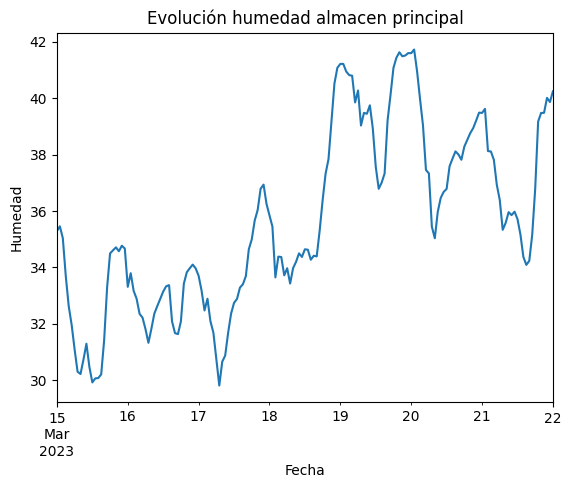

In [161]:
df_temp_hum_sample['07633_HI0101.PV'].plot(title='Evolución humedad almacen principal', xlabel='Fecha', ylabel='Humedad')

A diferencia de la temperatura, la humedad va en aumento con el paso del tiempo, subiendo en 7 días uno 10 "puntos"(¿menor control?)